# $$\triangleleft \triangleright$$
# <center>Backend
<center>The design mixes caching and Linux philosophy. Store the results of each step in a text file.

<center>We will start with a single topic search and work up to a model of meaning for any new page.

In [1032]:
database = './database'
def table(name, database=database):
    return f'{database}/{name}'

## $$\bigtriangledown$$
## <center>Topic Crawler 
## $$\bigtriangleup$$

In [ ]:
from requests import get
from time import sleep
from json import loads
from urllib.parse import unquote

In [3]:
topic_seed = ['user experience design']

In [1028]:
def crawl_topics(topic_seed, depth=2):
    topic_url_format = 'https://api.duckduckgo.com/?q={search_term}&format=json&pretty=1'
    topic_df = pd.DataFrame()
    related_topic_df = pd.DataFrame()
    for d in range(depth):
        if not d:
            topics = topic_seed
        related_topics = []
        topic_rows = []
        related_topic_rows = []
        for topic in topics:
            try:
                print(topic)
                # whoa there
                sleep(1.0)
                response = get(topic_url_format.format(search_term=topic))
                content = loads(response.content)
                data = {}
                data['topic'] = content['Heading'].lower()
                data['abstract'] = content['Abstract']
                data['document_type'] = content['Type']
                data['topic_wiki_url'] = content['AbstractURL']
                topic_rows.append(data)   

                for result in content['RelatedTopics']:
                    row = {}
                    row['depth'] = d
                    row['related_topic'] = unquote(result['FirstURL'].replace(
                        'https://duckduckgo.com/', '').replace('c/', '').replace('_', ' ')).lower()
                    row['related_topic_text'] = result['Text']
                    row.update(data)
                    related_topic_rows.append(row)
                    related_topics.append(row['related_topic'])
            # some topics are so ambiguous they have no URL
            except KeyError as e:
                print('Error on topic: ' + topic + ' : ' + str(e))
        topics = related_topics
        topic_df = topic_df.append(pd.DataFrame(topic_rows))
        related_topic_df = related_topic_df.append(pd.DataFrame(related_topic_rows))
    return topic_df, related_topic_df

In [1037]:
_, related_topic = crawl_topics(topic_seed)

user experience design
action research
activity-centered design
customer experience
design thinking
paper prototyping
participatory design
web design
software development process
user interfaces
human–computer interaction
design
Error on topic: design : 'FirstURL'


In [1038]:
related_topic.head()

,abstract,depth,document_type,related_topic,related_topic_text,topic,topic_wiki_url
0,User experience design is the process of manip...,0,A,action research,Action research - Action research is a philoso...,user experience design,https://en.wikipedia.org/wiki/User_experience_...
1,User experience design is the process of manip...,0,A,activity-centered design,Activity-centered design - Activity-centered d...,user experience design,https://en.wikipedia.org/wiki/User_experience_...
2,User experience design is the process of manip...,0,A,customer experience,"Customer experience - In commerce, customer ex...",user experience design,https://en.wikipedia.org/wiki/User_experience_...
3,User experience design is the process of manip...,0,A,design thinking,Design thinking - Design thinking refers to th...,user experience design,https://en.wikipedia.org/wiki/User_experience_...
4,User experience design is the process of manip...,0,A,paper prototyping,Paper prototyping - In human–computer interact...,user experience design,https://en.wikipedia.org/wiki/User_experience_...


In [1039]:
len(related_topic)

81

In [1040]:
related_topic.to_csv(table('related_topic.csv'))

## $$\bigtriangledown$$
## <center>Search Engine Crawler
## $$\bigtriangleup$$

In [1043]:
from getpass import getpass
bing_api_key = getpass()
# what is your azure cognitive services API key?

········


In [1047]:
search_seed = set(related_topic_df['related_topic'].unique())
search_seed.update(set(related_topic_df['topic'].unique()))
search_seed = list(search_seed)[:10]
len(search_seed)

10

In [1054]:
# this also works with bing dorks like "feed:"
def search(search_term):
    search_url = "https://api.cognitive.microsoft.com/bing/v7.0/search"
    headers = {"Ocp-Apim-Subscription-Key": bing_api_key}
    params = {
        "q": search_term, 
        "textDecorations": True, 
        "textFormat": "Raw", 
        "responseFilter": "webpages", # for some reason "webpages,relatedsearches" does not work
        "count": 50}
    sleep(1.0)
    response = get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_result = response.json()
    return search_result

In [1055]:
def filter_search_results(raw_search_results):
    keys = ['name', 'url', 'snippet', 'dateLastCrawled']
    for result in raw_search_results:
        topic = result['queryContext']['originalQuery']
        for page in result['webPages']['value']:
            row = {key: page[key] for key in keys}
            row['topic'] = topic
            yield row

In [1056]:
raw_search_result = [search(search_term=search_term) for search_term in search_seed]

In [1057]:
search_result = pd.DataFrame(filter_search_results(raw_search_results))

In [1058]:
search_result.head()

,dateLastCrawled,name,snippet,topic,url
0,2020-04-17T19:58:00.0000000Z,Lateral thinking - Wikipedia,Lateral thinking is a manner of solving prob...,lateral thinking,https://en.wikipedia.org/wiki/Lateral_thinking
1,2020-04-16T03:17:00.0000000Z,Lateral Thinking - How can Lateral Thinking...,Lateral Thinking Lateral Thinking is the S...,lateral thinking,https://www.edwddebono.com/lateral-thinking
2,2020-04-16T18:52:00.0000000Z,Lateral Thinking Puzzles - Preconceptions,Lateral thinking puzzles that challenge your...,lateral thinking,http://www.folj.com/lateral/
3,2020-04-17T00:42:00.0000000Z,How to Practice Lateral Thinking - ThoughtCo,Lateral thinking involves looking at a situa...,lateral thinking,https://www.thoughtco.com/lateral-thinking-185...
4,2020-04-17T20:46:00.0000000Z,What is Lateral Thinking? | Examples of Lat...,Lateral thinking means taking a creative app...,lateral thinking,https://successatschool.org/advicedetails/609/...


In [1059]:
len(search_result)

483

In [1060]:
search_result.to_csv(table('search_result.csv'))

## $$\bigtriangledown$$
## <center>Search Result Crawler
## $$\bigtriangleup$$

In [78]:
!pip install beautifulsoup4

In [1011]:
from bs4 import BeautifulSoup as b
from random import sample
from json import dump, loads

In [1062]:
def random_depth_crawl(seed_urls, depth=1, max_pages=10, max_links=5):
    visited = set()
    pages = 0
    for d in range(depth):
        next_seed_urls = set()
        for url in set(seed_urls):
            url.replace('http:', 'https:')
            if url not in visited:
                # only crawl each page one time
                visited.add(url)
                sleep(0.5)
                try:
                    response = get(url, timeout=5)
                    if response.status_code == 200:
                        content = response.content
                        # decode to make sure we can make sense of the content
                        yield {'url': url, 'content': content.decode()}
                        pages += 1
                        if pages > max_pages:
                            return
                        soup = b(content)
                        # choose random links to follow
                        links = [
                            a['href'] for a in soup.find_all('a', href=True)
                            if a['href'].startswith('https')]
                        n_links = min(len(links), max_links)
                        random_links = sample(links, n_links)
                        for link in random_links:
                            next_seed_urls.add(link)
                except Exception as e:
                    print('Error: ' + str(e) + ' on URL: ' + str(url))
        seed_urls = next_seed_urls

In [1067]:
seed_urls = search_result['url'].unique()

In [1068]:
max_pages = 10
raw_document_file = table('raw_document.txt')
for idx, document in enumerate(depth_crawl(seed_urls, max_pages=max_pages)):
    with open(raw_document_file, 'a') as f:
        dump(document, f)
        f.write('\n')

In [1075]:
def read_raw_document_file(raw_document_file):
    with open(raw_document_file, 'r') as f:
        for line in f.readlines():
            yield loads(line)

In [1076]:
raw_document = pd.DataFrame(read_raw_document_file(raw_document_file))

In [1077]:
raw_document.head()

,content,url
0,"<!DOCTYPE html> <html lang=""en""> <head> <meta ...",https://en.itu.dk/programmes/msc-programmes/so...
1,"<!DOCTYPE html><html lang=""en""><head><title>Th...",https://www.forbes.com/sites/phillewis1/2020/0...
2,"<!DOCTYPE html>\n<html lang=""en"" dir=""ltr""\n ...",https://www.truity.com/career-profile/graphic-...
3,"<!DOCTYPE html>\n<html class=""client-nojs"" lan...",https://www.wikihow.com/Think-Laterally
4,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",https://participaction.wordpress.com/2008/05/2...


In [1093]:
len(raw_document)

6

In [1161]:
document_topic = raw_document.merge(
    search_result,
    on='url')
td = document_topic # alias to make it concise below
# a document can be associated with multiple topics
td['topic_list'] = td.apply(lambda x: list(td[td['url'] == x['url']]['topic'].unique()), axis=1)

In [1162]:
document_topic.head()

,content,url,dateLastCrawled,name,snippet,topic,topic_list
0,"<!DOCTYPE html> <html lang=""en""> <head> <meta ...",https://en.itu.dk/programmes/msc-programmes/so...,2020-04-16T22:49:00.0000000Z,Software Design - ITU,Software Design is developed in close cooper...,software design,[software design]
1,"<!DOCTYPE html><html lang=""en""><head><title>Th...",https://www.forbes.com/sites/phillewis1/2020/0...,2020-04-17T22:10:00.0000000Z,The Most Valuable Skill In Difficult Times Is ...,Lateral thinking is the essence of creativit...,lateral thinking,[lateral thinking]
2,"<!DOCTYPE html>\n<html lang=""en"" dir=""ltr""\n ...",https://www.truity.com/career-profile/graphic-...,2020-04-16T01:53:00.0000000Z,Graphic Designer Career Profile | Job Descri...,Graphic design is important in the sales and...,graphic design,[graphic design]
3,"<!DOCTYPE html>\n<html class=""client-nojs"" lan...",https://www.wikihow.com/Think-Laterally,2020-04-16T16:06:00.0000000Z,How to Think Laterally: 13 Steps (with Pictu...,A key component in lateral thinking is curio...,lateral thinking,[lateral thinking]
4,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",https://participaction.wordpress.com/2008/05/2...,2020-04-17T08:13:00.0000000Z,Participatory research: Power and Proble...,Getting to grips with “what is participatory ...,participatory action research,[participatory action research]


In [1163]:
len(document_topic)

6

Consider doing more feature engineering, such as Unix epoch time, domain and TLD, number of topic nearest neighbors

## $$\bigtriangledown$$
## <center>Document-Topic Model
## $$\bigtriangleup$$

In [260]:
!pip install gensim

In [1097]:
from gensim.utils import simple_preprocess
from gensim.models import doc2vec

In [1098]:
def get_better_text(document):
    soup = b(document)
    for tag in soup(["script", "style"]):
        tag.extract()
    return soup.get_text() #.replace('\r', '\n')

In [1113]:
def count_tokens(document):
    return len(simple_preprocess(get_better_text(document)))

perform_count = True
if perform_count:
    prev = 0
    n_tokens = 0
    for idx, document in enumerate(document_topic['content']):
        n_tokens += count_tokens(document)
        if n_tokens - prev > 1000:
            prev = n_tokens
print(n_tokens)

12419


In [1164]:
def to_tokens(documents, index=None): 
    for idx, document in enumerate(documents):
        try:
            chars = str(get_better_text(document).encode())
            nchars = len(chars)
            frac_foreign_chars = chars.count('\\x')/nchars
            if frac_foreign_chars > 0.05:
                continue
        except (AttributeError, UnicodeDecodeError):
            continue
        tokens = simple_preprocess(get_better_text(document))
        value = idx
        if index is not None:
            value = index[idx]
        yield idx, doc2vec.TaggedDocument(tokens, value)

In [1165]:
# build training examples one by one, discarding malformed and non-English
n_train = 100 # maximum number of training examples
documents = document_topic['content'][:n_train]
index = document_topic['topic_list'][:n_train]

url_idx = []
train = []
for idx, val in enumerate(to_tokens(documents, index)):
    url_idx_, train_ = val
    url_idx.append(url_idx_)
    train.append(train_)

In [1166]:
# proceed only with the subset of documents that could be parsed
document_topic = document_topic.iloc[:, url_idx]
document_topic['train'] = train

In [1167]:
document_topic['n_tokens'] = document_topic['train'].apply(lambda training_example: len(training_example[0]))

In [1170]:
n_topics = len(set(document_topic['topic']))
n_tokens = document_topic['n_tokens'].sum()
n_documents = len(document_topic)
print(f'{n_topics} topics in corpus')
print(f'{n_documents} documents in corpus')
print(f'{n_tokens} tokens in corpus')

5 topics in corpus
6 documents in corpus
12419 tokens in corpus


In [1171]:
model = doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
model.build_vocab(train)

In [1172]:
model.train(train, total_examples=model.corpus_count, epochs=model.epochs)

In [1173]:
model.save(table('doc2vec.pkl'))

In [1177]:
n_model_topics = len(model.docvecs.offset2doctag)
print(f'{n_model_topics} topics in model')

5 topics in model


In [1178]:
ranks = []
second_ranks = []
for document in train:
    inferred_vector = model.infer_vector(document.words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    top, _ = sims[0]
    rank = top in document.tags
    ranks.append(rank)
    second_ranks.append(sims[1])

In [1179]:
correct_topic  = 100*sum(ranks)/len(test)
print(f'{correct_topic}% of documents indexed with at least one correct topic')

100.0% of documents indexed with at least one correct topic


In [1180]:
# associate doc2vec document vector with each parseable document
document_topic['inferred_vector'] = document_topic['train'].apply(lambda x: model.infer_vector(x.words))

In [1246]:
document_topic = document_topic.reset_index(drop=True)

$$C_{i} = \sum_{i\neq j}d_i\cdot d_j$$

In [1248]:
def cross_similarities(vector, norm=True):
    n = len(vector)
    print(n)
    size = n*n - n
    sums = pd.Series(n)
    sims = pd.Series(size)
    print(vector)
    for row, rv in enumerate(vector):
        for col, cv in enumerate(vector[row:]):
            col += row
            print((row, col))
            sim = rv.dot(cv)
            sims[row*col+row] = sim
            sums[row] += sim
            print('s')
            print(sums)
            sums[col] += sim
    if norm:
        sims /= sims.max()
        sums /= sums.max()
    return sims, sums 

In [1249]:
for topic, df in document_topic.groupby('topic'):
    print(topic)
    print(cross_similarities(df['inferred_vector']))

cardboard modeling
1
5    [-0.56035024, 0.03889051, -0.9215866, -0.84498...
Name: inferred_vector, dtype: object
(0, 0)
s
0    19
dtype: int64
(0    1.0
dtype: float64, 0    1.0
dtype: float64)
graphic design
1
2    [-10.754781, -2.0942776, -2.9712543, -10.40135...
Name: inferred_vector, dtype: object
(0, 0)
s
0    1184
dtype: int64
(0    1.0
dtype: float64, 0    1.0
dtype: float64)
lateral thinking
2
1    [-0.12904729, -4.1756306, -5.9906316, -3.98153...
3    [-3.5622163, -5.95154, -3.1059873, -2.3887193,...
Name: inferred_vector, dtype: object
(0, 0)
s
0    913
dtype: int64
(0, 1)
s
0    2769
dtype: int64


KeyError: 1

In [1185]:
cross_similarity(document_topic['inferred_vector'])

0    0.080021
1    0.751979
2    0.976080
3    1.000000
4    0.890460
5    0.015130
6    0.283222
8    0.080862
9    0.068474
dtype: float64

In [887]:
inferred_vectors = {
    topic: pd.DataFrame([
        {
            'url': full_results_df['url'][idx],
            'vector': model.infer_vector(document.words)}
        for idx, document in zip(url_idx, train)
        if topic in document.tags])
    for topic in model.docvecs.offset2doctag}

In [888]:
similarities = {}
for topic in inferred_vectors:
    similarities[topic] = []
    for uidx, urow in inferred_vectors[topic].iterrows():
        for lidx, lrow in inferred_vectors[topic][uidx:].iterrows():
            similarities[topic].append(urow['vector'].dot(lrow['vector']))
    similarities[topic] = pd.Series(similarities[topic])
    similarities[topic] /= similarities[topic].max()

In [889]:
topic_similarities = {}
for topic in inferred_vectors:
    topic_similarities[topic] = inferred_vectors[topic].apply(
        lambda x: x['vector'].dot(model.docvecs[topic]), axis=1)
    topic_similarities[topic] = pd.Series(topic_similarities[topic])
    topic_similarities[topic] /= topic_similarities[topic].max()

In [903]:
cross_similarities = {}
for topic in similarities:
    documents = similarities[topic]
    n_documents = len(topic_similarities[topic])
    cross_similarities[topic] = pd.Series(np.zeros(n_documents))
    for idx, sim in enumerate(documents):
        i = idx % n_documents
        j = idx // n_documents
        cross_similarities[topic][i] += sim
        if i != j:
            cross_similarities[topic][j] += sim
for topic in similarities:
    cross_similarities[topic] /= cross_similarities[topic].max()

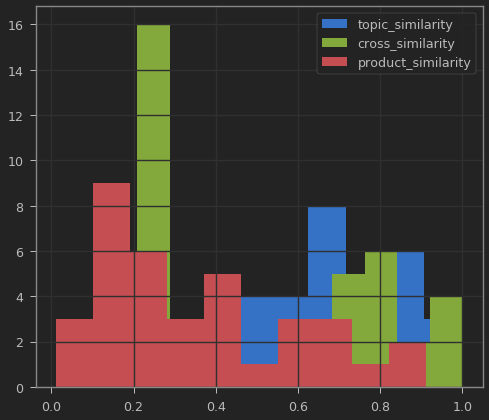

In [921]:
fig, ax = plt.subplots()
keys = ['topic_similarity', 'cross_similarity', 'product_similarity']
for key in keys:
    playlist[key].hist(ax=ax)
ax.legend(keys)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66327b1320>,
      dtype=object)

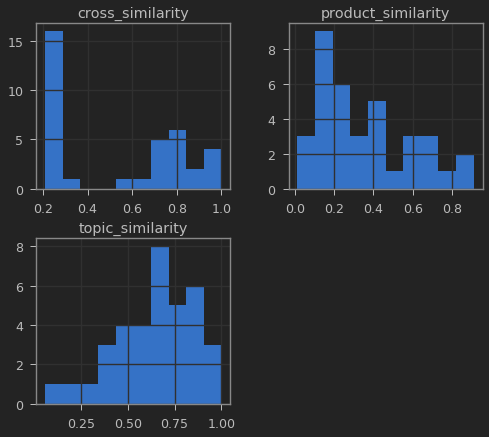

In [919]:
playlist[['topic_similarity', 'cross_similarity', 'product_similarity']].hist()

In [926]:
topic = 'outline of software engineering'
playlist = full_results_df[full_results_df['topic'] == topic].copy().reset_index(drop=True)
playlist['topic_similarity'] = topic_similarities[topic]
playlist['cross_similarity'] = cross_similarities[topic]
playlist['product_similarity'] = playlist['cross_similarity']*playlist['topic_similarity']
playlist.sort_values('product_similarity', ascending=False)['url'].values

array(['https://en.wikipedia.org/wiki/Outline_of_software_engineering',
       'http://ecomputernotes.com/software-engineering/principles-of-software-design-and-concepts',
       'http://nust.edu.pk/INSTITUTIONS/Schools/SEECS/ap/ug/BSE/Pages/default.aspx',
       'https://patilpankaj.files.wordpress.com/2016/06/unit-iii1.pdf',
       'https://www.cs.cmu.edu/~aldrich/courses/413/',
       'http://www.cs.cornell.edu/courses/cs501/2005sp/syllabus.html',
       'https://sites.google.com/site/ugcpen207/course-outline',
       'https://www.template.net/business/proposal-templates/engineering-project-proposal-template/',
       'https://www.bartleby.com/essay/software-engineering-P3ML2NYTC',
       'https://www.tutorialspoint.com/software_engineering/software_project_management.htm',
       'https://www.bartleby.com/essay/Software-Engineering-Detailed-Documentation-Outline-F3DXQY8K8RTA',
       'https://www.manchester.ac.uk/study/undergraduate/courses/2020/05125/bsc-software-engineering/cours

In [840]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [841]:
import numpy as np
def max_hist(df, ax):
    df.hist(ax=ax, bins=20, weights=np.ones_like(df) * 100. / len(df))

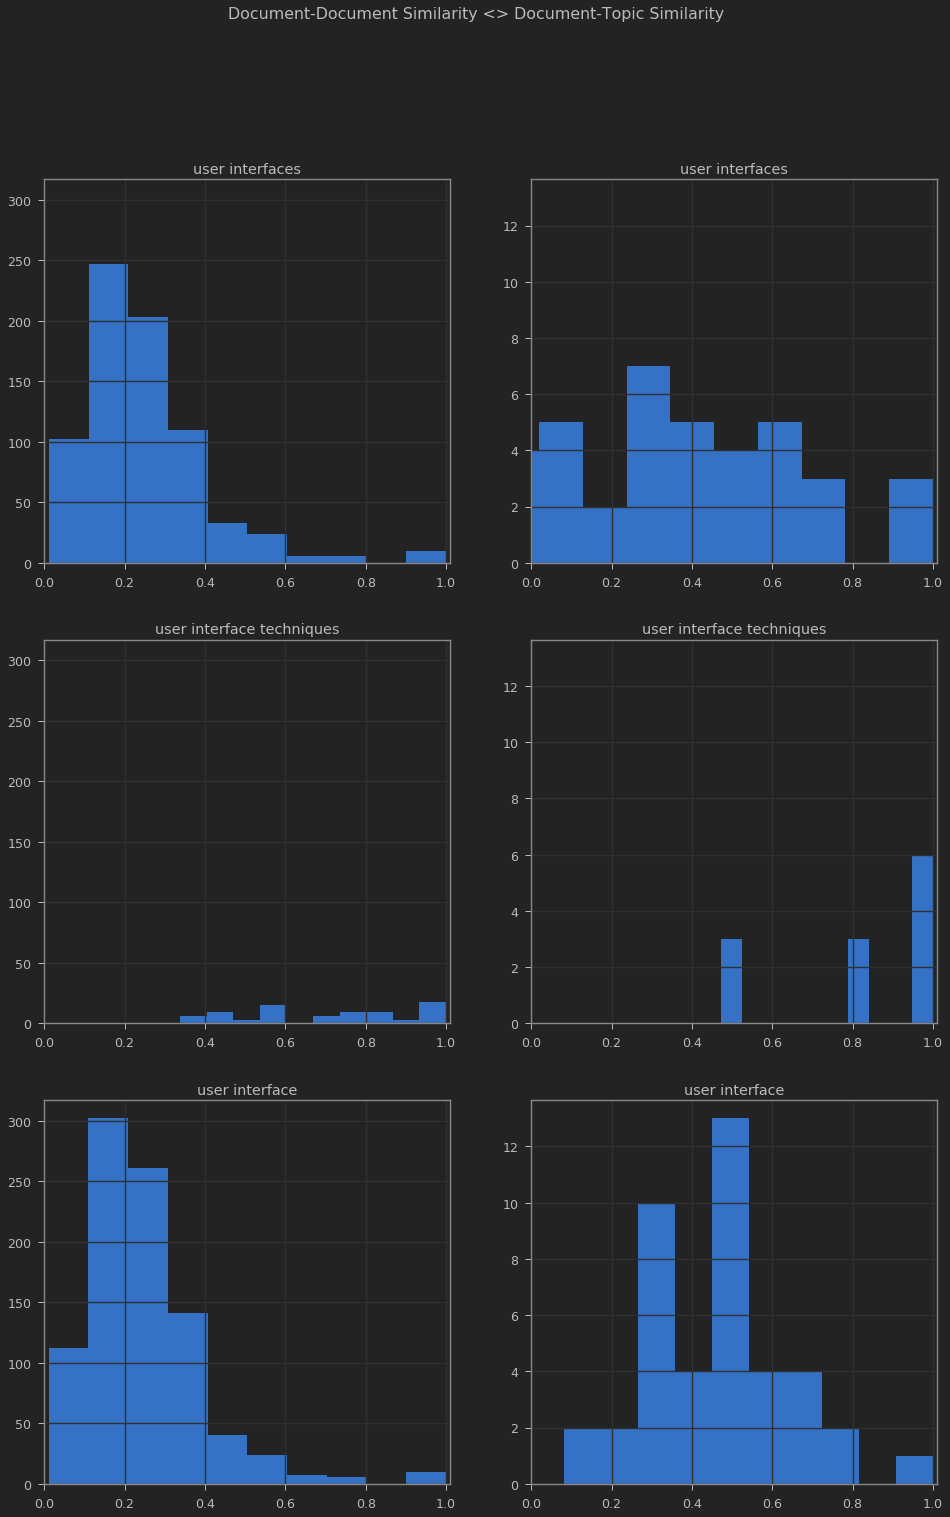

In [842]:
n_rows = 3
fig, ax = plt.subplots(n_rows, 2, figsize=(16, 24))
max_ly = 1
max_ry = 1
for idx, topic in enumerate(reversed(sorted(list(similarities)))):
    if idx > n_rows-1:
        break
    left = ax[idx, 0]
    right = ax[idx, 1]
    left.title.set_text(topic)
    right.title.set_text(topic)
    #max_hist(similarities[topic], ax=left)
    #max_hist(topic_similarities[topic], ax=right)
    similarities[topic].hist(ax=left)
    topic_similarities[topic].hist(ax=right)
    max_ly = max(max_ly, left.get_ylim()[1])
    max_ry = max(max_ry, right.get_ylim()[1])
    left.set_xlim((0, 1.01))
    right.set_xlim((0, 1.01))
    
for idx, topic in enumerate(similarities):
    if idx > n_rows-1:
        break
    left = ax[idx, 0]
    right = ax[idx, 1]
    left.set_ylim((0, max_ly))
    right.set_ylim((0, max_ry))
    
fig.suptitle('Document-Document Similarity <> Document-Topic Similarity');
fig.savefig('similarity.png')

In [680]:
len(similarities['participatory action research'])

528

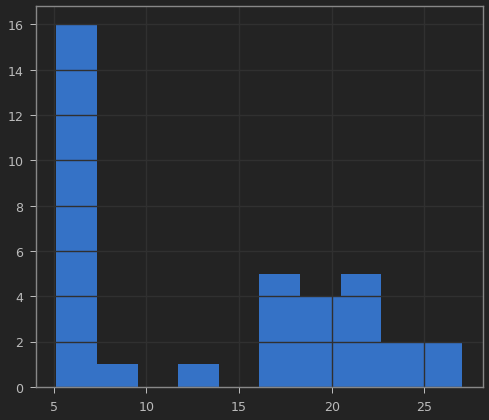

In [820]:
cross_similarities['lateral thinking'].hist()

In [726]:
foreign = full_results_df[
    full_results_df['url'] == 'https://www.thaiprogrammer.org/2018/12/ui-vs-ux-%E0%B8%AD%E0%B8%B0%E0%B9%84%E0%B8%A3%E0%B8%84%E0%B8%B7%E0%B8%AD%E0%B8%84%E0%B8%A7%E0%B8%B2%E0%B8%A1%E0%B9%81%E0%B8%95%E0%B8%81%E0%B8%95%E0%B9%88%E0%B8%B2%E0%B8%87%E0%B8%A3%E0%B8%B0%E0%B8%AB/']['content']

In [729]:
foreign[201]

b'<!DOCTYPE html>\n<html lang="en-US">\n<head>\n    <meta charset="UTF-8" />\n    <meta http-equiv="X-UA-Compatible" content="IE=edge">\n    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0, user-scalable=yes"/>\n    <title>UI vs. UX: \xe0\xb8\xad\xe0\xb8\xb0\xe0\xb9\x84\xe0\xb8\xa3\xe0\xb8\x84\xe0\xb8\xb7\xe0\xb8\xad\xe0\xb8\x84\xe0\xb8\xa7\xe0\xb8\xb2\xe0\xb8\xa1\xe0\xb9\x81\xe0\xb8\x95\xe0\xb8\x81\xe0\xb8\x95\xe0\xb9\x88\xe0\xb8\xb2\xe0\xb8\x87\xe0\xb8\xa3\xe0\xb8\xb0\xe0\xb8\xab\xe0\xb8\xa7\xe0\xb9\x88\xe0\xb8\xb2\xe0\xb8\x87 user interface \xe0\xb9\x81\xe0\xb8\xa5\xe0\xb8\xb0 user experience - \xe0\xb8\xa3\xe0\xb8\xb2\xe0\xb8\x8a\xe0\xb9\x80\xe0\xb8\x97\xe0\xb8\xa7\xe0\xb8\xb5, \xe0\xb8\x81\xe0\xb8\xa3\xe0\xb8\xb8\xe0\xb8\x87\xe0\xb9\x80\xe0\xb8\x97\xe0\xb8\x9e\xe0\xb8\xaf, \xe0\xb8\x9b\xe0\xb8\xa3\xe0\xb8\xb0\xe0\xb9\x80\xe0\xb8\x97\xe0\xb8\xa8\xe0\xb9\x84\xe0\xb8\x97\xe0\xb8\xa2 | Thai Programmer Association</title>\n        <link rel="ping

In [748]:
b'\xb8'.count(b'x')

0

In [848]:
str(get_better_text(foreign[201]).encode()).count('\\x')/len(str(get_better_text(foreign[201]).encode())) > 0.05

True

In [755]:
str(get_better_text(full_results_df['content'][203]).encode()).count('\\x')

34

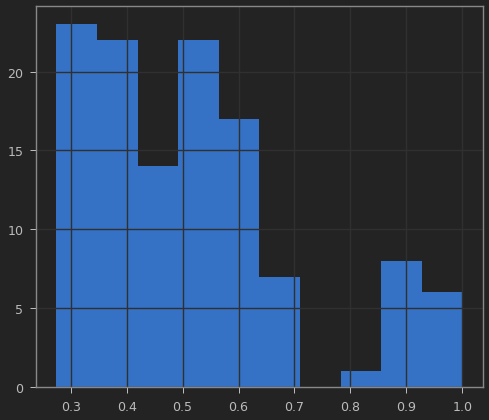

In [554]:
similarities['user interface'].hist()

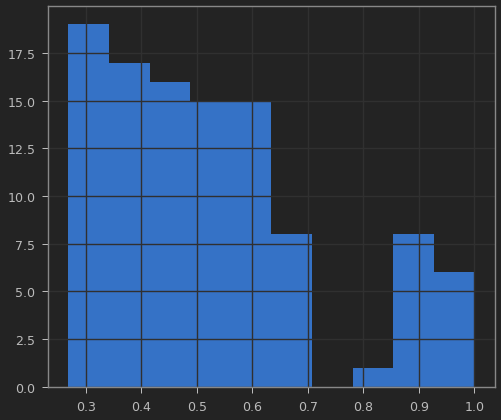

In [553]:
similarities['user interfaces'].hist()

In [971]:
for topic in similarities:
    print((topic, len(similarities[topic])))

('lateral thinking', 666)
('services marketing', 666)
('participatory action research', 528)
('prototype', 780)
('paper prototyping', 903)
('user interface', 1128)
('user interfaces', 1128)
('adaptive user interface', 780)
('distinguishable interfaces', 1)
('user interface techniques', 780)
('user experience design', 861)
('user experience', 946)
('software prototyping', 1)
('user-centered design', 10)
('service design', 1)
('cardboard modeling', 703)
('software design', 903)
('design', 703)
('graphic design', 903)
('virtual reality', 595)
('participatory design', 561)
('design methods', 1)
('brain-computer interface', 741)
('information design', 741)
('human–computer interaction', 1081)
('human-computer interaction', 990)
('human–machine interaction', 6)
('communication design', 1081)
('computer-supported cooperative work', 861)
('problem solving', 820)
('problem structuring methods', 496)
('social science methodology', 741)
('methodology', 861)
('mindfulness and technology', 780)
('s

In [496]:
full_results_df[full_results_df['topic'] == 'user interface']['url']

160    https://searchapparchitecture.techtarget.com/d...
162    https://searchapparchitecture.techtarget.com/d...
164         https://en.wikipedia.org/wiki/User_interface
168         https://en.wikipedia.org/wiki/User_interface
172         https://en.wikipedia.org/wiki/User_interface
176    https://www.usability.gov/what-and-why/user-in...
179    https://www.usability.gov/what-and-why/user-in...
182    https://www.usability.gov/what-and-why/user-in...
185    https://www.webopedia.com/TERM/U/user_interfac...
187    https://www.webopedia.com/TERM/U/user_interfac...
189    https://en.wikipedia.org/wiki/Graphical_user_i...
190    http://www.businessdictionary.com/definition/u...
192    http://www.businessdictionary.com/definition/u...
194    https://www.interaction-design.org/literature/...
197    https://www.interaction-design.org/literature/...
200    https://www.interaction-design.org/literature/...
203    https://www.tutorialspoint.com/software_engine...
206    https://www.tutorialspoi

In [498]:
search_results[search_results['topic'] == 'user interface']['url']

196    https://searchapparchitecture.techtarget.com/d...
197         https://en.wikipedia.org/wiki/User_interface
198    https://www.usability.gov/what-and-why/user-in...
199    https://www.webopedia.com/TERM/U/user_interfac...
200    https://en.wikipedia.org/wiki/Graphical_user_i...
201    http://www.businessdictionary.com/definition/u...
202    https://www.interaction-design.org/literature/...
203    https://www.tutorialspoint.com/software_engine...
204     https://www.dictionary.com/browse/user-interface
205    https://support.microsoft.com/en-us/office/cho...
206         https://vivaldi.com/features/user-interface/
207    https://www.everyinteraction.com/definition/us...
208                           https://userinyerface.com/
209    https://www.w3computing.com/systemsanalysis/ty...
210      https://techterms.com/definition/user_interface
211    https://idseducation.com/articles/apa-itu-user...
212         https://www.dewaweb.com/blog/user-interface/
213    https://www.udacity.com/